In [ ]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython tensorflow

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Recurrent Neural Networks

> The nervous system contains many circular paths, whose activity so regenerates the excitation of any participant neuron that reference to time past becomes indefinite, although it still implies that afferent activity has realized one of a certain class of configurations over time. Precise specification of these implications by means of recursive functions, and determination of those that can be embodied in the activity of nervous nets, completes the theory.
> 
> -- Warren McCulloch and Walter Pitts, 1943

A recurrent neural network (RNN) is a type of artificial neural network that uses sequential data or time series data and it is mainly used for Natural Language Processing. Now let us see what it looks like.

Sequential data is not [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables).

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/RNN/sequential_data.png
---
name: 'sequential data'
width: 90%
---
sequential data
:::

And the RNNs use recurrent edge to update.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/RNN/rnn1.png
---
name: 'RNN1'
width: 90%
---
RNN1
:::

If unroll over a sequence $(x_0,x_1,x_2)$.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/RNN/rnn2.png
---
name: 'RNN2'
width: 90%
---
RNN2
:::

Then, the input (w0,w1,...,wt) sequence of words ( 1-hot encoded ) and the output (w1,w2,...,wt+1) shifted sequence of words ( 1-hot encoded ) have the following relation.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/RNN/rnn3.png
---
name: 'RNN3'
width: 90%
---
RNN3
:::

The input projection is $x_t = Emb(\omega_t) = E\omega_t$, the recurrent connection is $h_t = g(W^h h_t + x_t + b^h)$, and the output projection should be $y = softmax(W^o h_t + b^o)$.
The backpropagation of RNN is in this way:

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/RNN/rnn4.png
---
name: 'RNN4'
width: 90%
---
RNN4
:::

Let's make the backpropagation process more clearly.

First, we unfold a single-hidden layer RNN, and we can see the weight matrices $W_h$ in it.

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/RNN/bp_rnn1.png
---
name: 'backpropagation for RNN'
width: 90%
---
backpropagation for RNN
:::

Through the image, we can get the output:

- Net input: $z_h^{<t>} = W_hx x^{<t>} + W_hh h^{<t-1>} + b_h$
- Activation: $h^{<t>} = \sigma (z_h^{<t>})$
- Output: $z_y^<t> = W_yh h^{<t>} + b_y$, $y^{<t>} = \sigma(z_y^{<t>})$

After that, the loss is computed as the sum over all time steps: $L = \sum_{t=1}^T L^{<t>}$

:::{note}
There are some key points:

- Similar as training very deep networks with tied parameters.
- Example between $x_0$ and $y_2$: Wh is used twice.
- Usually truncate the backprop after $T$ timesteps.
- Difficulties to train long-term dependencies.
:::

## Code

A text classifier implemented in TensorFlow to classify SMS spam messages.
Code first downloads and processes the SMS Spam Collection dataset from the UCI Machine Learning Repository and then builds a basic Recurrent neural network (RNN) for text classification using TensorFlow.
The code first cleans and preprocesses the text, then splits it into training and test sets, followed by tokenizing and padding the training set. Next, the code uses an embedding layer to convert the tokenized text into a vector representation, which is then fed into a recurrent neural network and finally classified using a Softmax loss function.
The output of the # code is the accuracy of the classifier along with some statistics
We implement an RNN in TensorFlow to predict spam/ham from texts

In [2]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Download or open data
data_dir = "tmp"
data_file = "text_data.txt"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read("SMSSpamCollection")
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode("ascii", errors="ignore")
    text_data = text_data.decode().split("\n")

    # Save data to text file
    with open(os.path.join(data_dir, data_file), "w") as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), "r") as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split("\t") for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [4]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r"([^\s\w]|_|[0-9])+", "", text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string

In [5]:
# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]
print(text_data_train[:5])

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data_train)
text_processed = tokenizer.texts_to_sequences(text_data_train)
max_sequence_length = 25
text_processed = pad_sequences(
    text_processed, maxlen=max_sequence_length, padding="post"
)
print(text_processed.shape)

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat', 'ok lar joking wif u oni', 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs', 'u dun say so early hor u c already then say', 'nah i dont think he goes to usf he lives around here though']
(5574, 25)


Vocabulary Size: 8630
80-20 Train Test split: 4459 -- 1115
Epoch 1/20
15/15 [==============================] - 4s 107ms/step - loss: 0.5348 - accuracy: 0.7951 - val_loss: 0.4411 - val_accuracy: 0.9025
Epoch 2/20
15/15 [==============================] - 0s 20ms/step - loss: 0.4310 - accuracy: 0.8814 - val_loss: 0.3498 - val_accuracy: 0.9540
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 0.3542 - accuracy: 0.9277 - val_loss: 0.2880 - val_accuracy: 0.9664
Epoch 4/20
15/15 [==============================] - 1s 45ms/step - loss: 0.3058 - accuracy: 0.9445 - val_loss: 0.2443 - val_accuracy: 0.9675
Epoch 5/20
15/15 [==============================] - 1s 45ms/step - loss: 0.2615 - accuracy: 0.9588 - val_loss: 0.2178 - val_accuracy: 0.9630
Epoch 6/20
15/15 [==============================] - 1s 46ms/step - loss: 0.2295 - accuracy: 0.9610 - val_loss: 0.1918 - val_accuracy: 0.9686
Epoch 7/20
15/15 [==============================] - 1s 36ms/step - loss: 0.2096 - accuracy: 0.

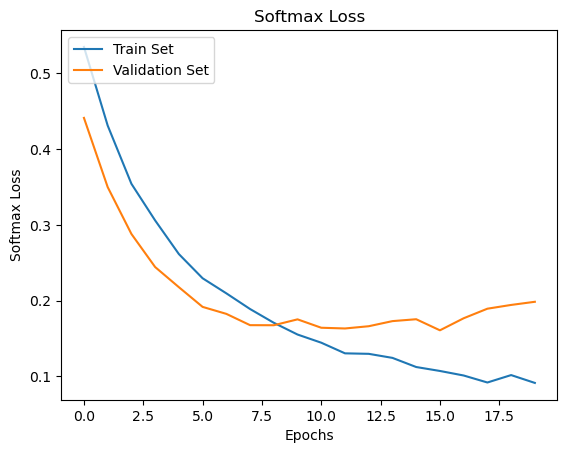

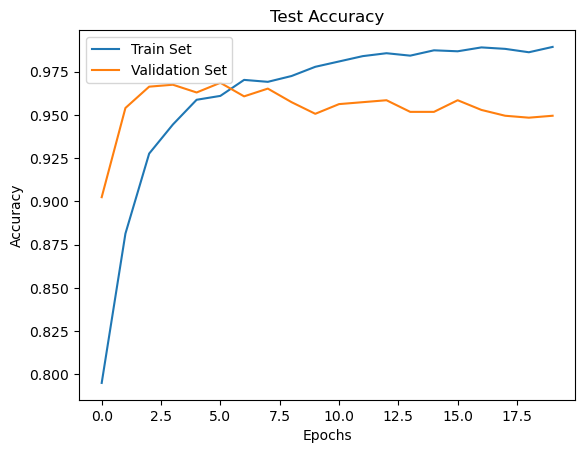

In [6]:
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == "ham" else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled) * 0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

# Create the model using the Sequential API
embedding_size = 50
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_size,
            input_length=max_sequence_length,
        ),
        tf.keras.layers.SimpleRNN(units=10),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=2, activation="softmax"),
    ]
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
epochs = 20
batch_size = 250

history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2
)

# Plot loss and accuracy over time
plt.plot(history.history["loss"], label="Train Set")
plt.plot(history.history["val_loss"], label="Validation Set")
plt.title("Softmax Loss")
plt.xlabel("Epochs")
plt.ylabel("Softmax Loss")
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history["accuracy"], label="Train Set")
plt.plot(history.history["val_accuracy"], label="Validation Set")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

## Your turn! 🚀

You can practice your rnn skills by following the assignment [google stock price prediction rnn](../assignments/deep-learning/rnn/google-stock-price-prediction-rnn.ipynb)

## Self study

TBD

## Acknowledgments

Thanks to [Nick](https://github.com/nfmcclure) for creating the open-source course [tensorflow_cookbook](https://github.com/nfmcclure/tensorflow_cookbook) and [Sebastian Raschka](https://github.com/rasbt) for creating the open-sourse [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20). It inspires the majority of the content in this chapter.
